In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# 使用示例
filename = 'hitlog-code_debug_277-llama3_8B.log'  # 你的文件名
num_layer = 32
init_block = 1
local_block = 32
block_size = 128

In [3]:
def process_access_history(filename, num_layer, init_block, local_block, block_size):
    # 创建计数数组
    
    
    # 读取文件并统计每个 block 的访问次数
    with open(filename, 'r') as f:
        sum_tokens = int(f.readline())
        num_mid_tokens = sum_tokens - (init_block + local_block) * block_size
        num_blocks = (num_mid_tokens+block_size-1)//block_size-1 + init_block + local_block
        block_counts = np.zeros([num_layer, num_blocks])
        block_access_records = list()
        cur_layer = 0
        for line in f:
            # 将字符串转换为 list
            blocks = eval(line.strip())
            for block_id in range(init_block):
                block_counts[cur_layer][block_id] += 1
            for block_id in range(local_block):
                block_counts[cur_layer][num_blocks - local_block + block_id] += 1
            block_access_records.append(blocks)
            # 统计每个 block 的出现次数
            for block_id in blocks:
                block_counts[cur_layer][block_id+init_block]+= 1
               
            cur_layer = (cur_layer + 1)%num_layer

        assert cur_layer == 0
    return block_counts, block_access_records
block_counts, block_access_records = process_access_history(filename, num_layer, init_block, local_block, block_size)

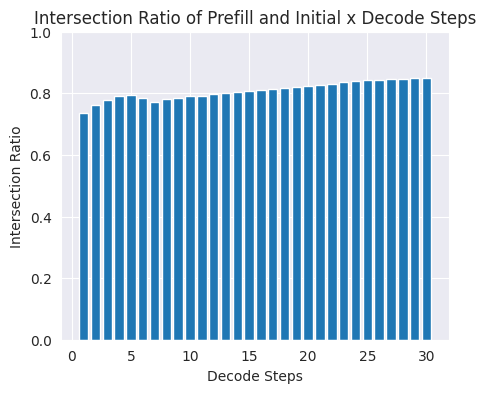

In [4]:
def calc_pd_intersection(block_access_records, num_layer, decode_num):
    prefill_block_hits = list()
    miss_counts = list()
    for i in range(num_layer):
        prefill_block_hits.append(block_access_records[i])
        miss_counts.append(0)
    decode_access_records = block_access_records[num_layer:num_layer+decode_num]
    for i in range(len(decode_access_records)):
        layer_id = i % num_layer
        for block_id in decode_access_records[i]:
            if block_id not in prefill_block_hits[layer_id]:
                miss_counts[layer_id]+=1
    total_chocies = sum(len(decode_access_record) for decode_access_record in decode_access_records)
    missed_chocies = sum(miss_counts)
    return 1-missed_chocies/total_chocies

def plot_pd_intersection(block_access_records, num_layer, max_steps):
    plt.figure(figsize=(5, 4))
    x = list(range(1, max_steps+1))
    y = list()
    for i in range(1, max_steps+1):
        y.append(calc_pd_intersection(block_access_records, num_layer, i))
    plt.bar(x,y)
    plt.xlabel('Decode Steps')
    plt.ylabel('Intersection Ratio')
    plt.title('Intersection Ratio of Prefill and Initial x Decode Steps')
    plt.ylim(0, 1)
    
    plt.show()
plot_pd_intersection(block_access_records, num_layer, 30)


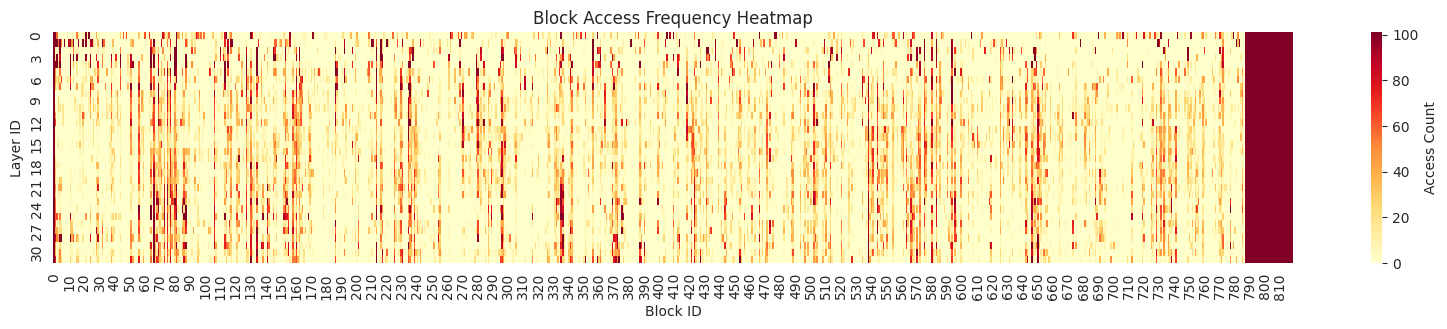

In [5]:
def plot_access_heatmap(heatmap_data):
    plt.figure(figsize=(20, 3))
    sns.heatmap(heatmap_data, 
                cmap='YlOrRd',  # 使用黄-橙-红色系
                annot=False,    # 不显示具体数值
                fmt='.0f',
                cbar_kws={'label': 'Access Count'})
    
    plt.title('Block Access Frequency Heatmap')
    plt.xlabel('Block ID')
    plt.ylabel('Layer ID')
    plt.show()
plot_access_heatmap(block_counts)

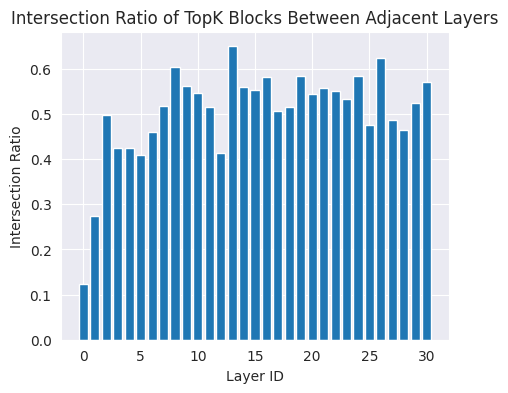

In [6]:
def calc_layer_intersection_ratio(block_access_records, num_layer):
    layer_intersection_ratio = [[] for _ in range(num_layer-1)]
    for i, cur_layer_block_access in enumerate(block_access_records):
        layer_id = i % num_layer
        if i == len(block_access_records)-1:
            break
        if layer_id == num_layer-1:
            continue
        next_layer_block_access = block_access_records[i+1]
        # 计算两个 list 之间元素的重合度
        intersection = set(cur_layer_block_access) & set(next_layer_block_access)
        intersection_ratio = len(intersection) / len(set(next_layer_block_access))
        layer_intersection_ratio[layer_id].append(intersection_ratio)
    layer_intersection_ratio = [np.mean(similarity) for similarity in layer_intersection_ratio]
    return layer_intersection_ratio
layer_intersection_ratio = calc_layer_intersection_ratio(block_access_records, num_layer)

def plot_layer_intersection_ratio(layer_intersection_ratio):
    plt.figure(figsize=(5, 4))
    plt.bar(list(range(num_layer-1)), layer_intersection_ratio)
    plt.title('Intersection Ratio of TopK Blocks Between Adjacent Layers')
    plt.xlabel('Layer ID')
    plt.ylabel('Intersection Ratio')
    plt.show()
plot_layer_intersection_ratio(layer_intersection_ratio)



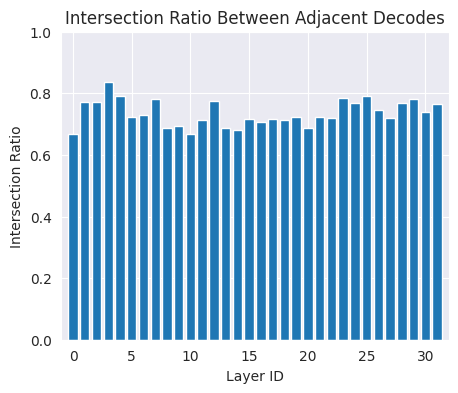

In [7]:
def calc_query_intersection(block_access_records, num_layer):
    query_intersection = [[] for _ in range(num_layer)]
    for i, cur_layer_block_access in enumerate(block_access_records):
        layer_id = i % num_layer
        if i+num_layer >= len(block_access_records):
            break
        next_layer_block_access = block_access_records[i+num_layer]
        # 计算两个 list 之间元素的重合度
        intersection = set(cur_layer_block_access) & set(next_layer_block_access)
        intersection_ratio = len(intersection) / len(set(next_layer_block_access))
        query_intersection[layer_id].append(intersection_ratio)
    query_intersection = [np.mean(similarity) for similarity in query_intersection]
    return query_intersection

def plot_query_intersection(query_intersection):
    plt.figure(figsize=(5, 4))
    plt.bar(list(range(num_layer)), query_intersection)
    plt.title('Intersection Ratio Between Adjacent Decodes')
    plt.xlabel('Layer ID')
    plt.ylabel('Intersection Ratio')
    plt.xlim(-1, num_layer)
    plt.ylim(0, 1)
    plt.show()

query_intersection = calc_query_intersection(block_access_records, num_layer)
plot_query_intersection(query_intersection)


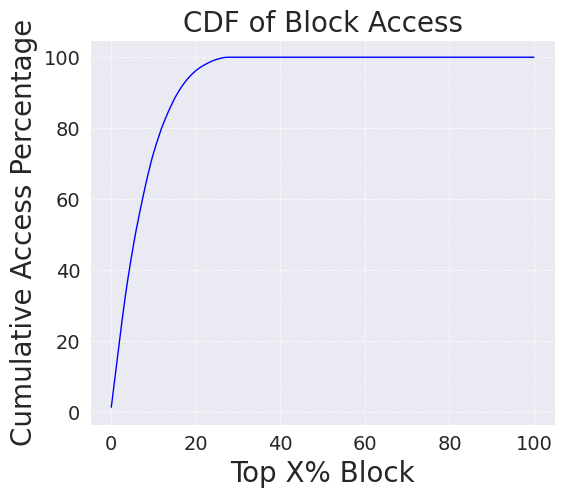

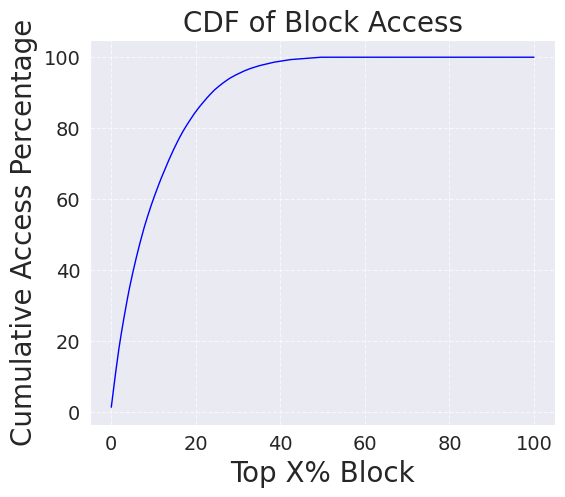

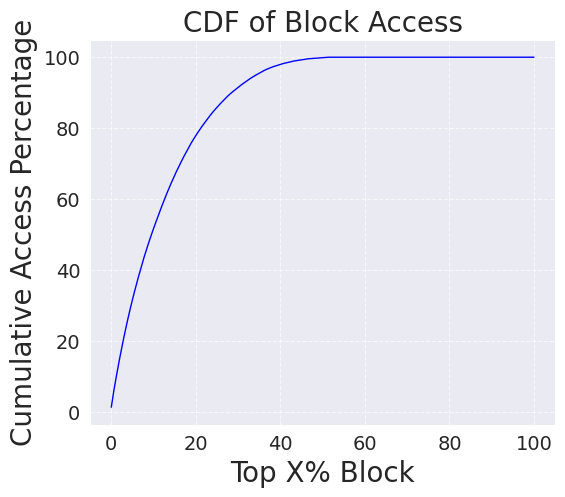

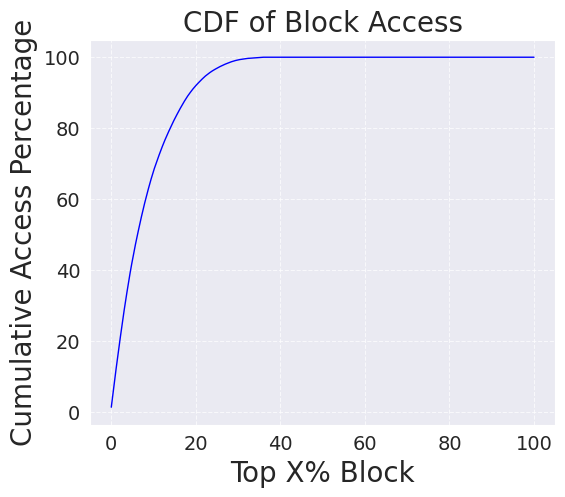

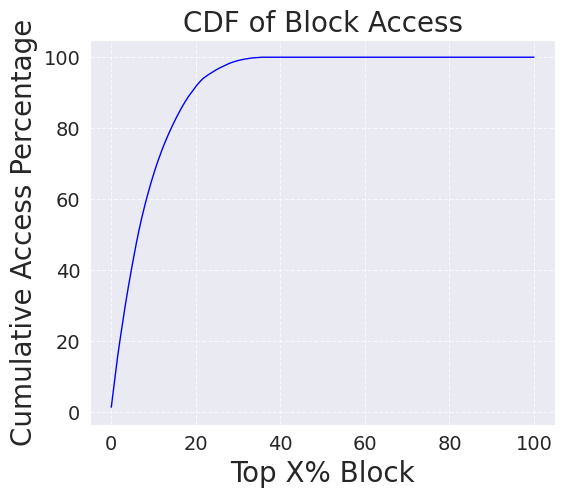

In [8]:
def plot_access_cdf(block_counts):
    
    # 对 block_counts 进行降序排序
    sorted_counts = np.sort(block_counts)[::-1]
    # 计算累计访问次数
    cumulative_counts = np.cumsum(sorted_counts)
    # 转换为占比
    cumulative_percent = cumulative_counts / cumulative_counts[-1] * 100
    # 生成对应的 x 轴数据（top-x% 的 block）
    x_percent = np.linspace(0, 100, len(cumulative_percent))
    
    # 绘制 CDF 图
    plt.figure(figsize=(6, 5))
    
    plt.plot(x_percent, cumulative_percent, 'b-', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel('Top X% Block', fontsize=20)
    plt.ylabel('Cumulative Access Percentage', fontsize=20)
    plt.title('CDF of Block Access', fontsize=20)    
    plt.show()

# plot_access_cdf(block_counts[0])
plot_access_cdf(block_counts[0][:-local_block])
# plot_access_cdf(block_counts[8])
plot_access_cdf(block_counts[8][:-local_block])
# plot_access_cdf(block_counts[16])
plot_access_cdf(block_counts[16][:-local_block])
# plot_access_cdf(block_counts[24])
plot_access_cdf(block_counts[24][:-local_block])
# plot_access_cdf(block_counts[31])
plot_access_cdf(block_counts[31][:-local_block])